# Deep Learning IISC Project 
**KoEngage: Threads of tongue; Supervised Adaptation of LLMs for Korean-English Translation** 
* Facebook's opensource mBART-model is used for Machine Translation Task, which is an encoder-decoder transformer
* Bleu, BERTScore and chrF evaluation metrics are calculated on pre-trained mBART model
* Model is Supervised Fine Tuned on Korean, English Corpus
* Evaluation Metrics are calculated again

# Import Modules
We import the tokenizer MBART50TokenizerFast and model MBartForConditionalGeneration, provided by Hugging Face transformer library
Evaluate Module is used for Bleu score calculation provided by Hugging Face

In [1]:
from transformers import MBart50TokenizerFast, MBartForConditionalGeneration
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from time import time
!pip install evaluate
!pip install bert-score
!pip install sacrebleu
import evaluate
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
from torch.optim import AdamW

2025-06-18 17:08:51.089655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750266531.271936      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750266531.325836      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

# Wandb API login

In [2]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")
wandb.login(key=secret_value_0)
wandb.init(project="Train mBART on Wiki Matrix_test_3_100k_pairs",
          config={
              "batch_size" : 5,
              "learning_rate" : 3e-5,
              "Number_of_epochs" : 1,
              "Training_data" : "Training on wiki matrix",
              "Evaluation_data" : "Evaluation on AI HUB data"
          })

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mustqueahmed46 (mustqueahmed46-indian-institute-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# System Details

In [8]:
os.system("lscpu")
!free -h
!nvidia-smi


Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               4
On-line CPU(s) list:                  0-3
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz
CPU family:                           6
Model:                                85
Thread(s) per core:                   2
Core(s) per socket:                   2
Socket(s):                            1
Stepping:                             3
BogoMIPS:                             4000.22
Flags:                                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 

# Seed data is provided for non-random output at different runs.

In [3]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# mBART Model Load
* Facebooks mBART model is loaded and the tokenizer.
* Before loading CPU availability is checked
* mBART has language codes for source and target language identification for tokenization
* ko_KR-> Korean Text
* en_XX-> English Text
* The decoder is set for English

In [4]:
#model name is mBART
#model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBart50TokenizerFast.from_pretrained("/kaggle/input/mbart-ai-hub-sft-token/mbart-large-50-many-to-many-mmt-finetuning-token")
if(torch.cuda.is_available()):
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using {DEVICE}")
model = MBartForConditionalGeneration.from_pretrained("/kaggle/input/mbart-ai-hub-sft-model/mbart-large-50-many-to-many-mmt-finetuning")
if torch.cuda.device_count() > 1:
    print("Multiple GPUs detected, using DataParallel!")
    model = nn.DataParallel(model)  # Wrap the model for multi-GPU
model = MBartForConditionalGeneration.from_pretrained("/kaggle/input/mbart-ai-hub-sft-model/mbart-large-50-many-to-many-mmt-finetuning").to(DEVICE)
tokenizer.src_lang = "ko_KR"
tokenizer.tgt_lang = "en_XX"
#mBART use special language token for identification
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids("en_XX")



Using cuda


# Model Parameters
mBART models parameters are printed.

In [5]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

610,879,488 total parameters.
610,879,488 training parameters.
MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc

# Data corpus load for training from AI HUB 
https://aihub.or.kr/

For data type in the following format:

[
	{ # example of the 1st article
        'catagory' : ['문화', '학술_문화재'],
        'date' : '2019-05-31T00:00:00.000Z',
        'source' : '국민일보',
        'text' :
        	[
                { # example of the 1st sentence in the 1st article
                'aihub_id' : 1530019,
                'en_ko_ner_gold' : [[0, 0], [2, 1]],
                'en_ner_auto' : [[2, 3, 'DATE'], [4, 8, 'ORG'], [22, 27, 'DATE']],
                'en_ner_gold' : [[2, 3, 'DATE'], [5, 8, 'ORG'], [22, 27, 'CARDINAL']],
                'en_text' : 'Founded in 1990, the Special Needs Institute has developed a variety of curative programs to study brain development and educate children under the age of 5 with developmental disabilities and autism.',
                'en_tokens' : ['Founded', 'in', '1990', ',', 'the', 'Special', 'Needs', 'Institute', 'has', 'developed', 'a', 'variety', 'of', 'curative', 'programs', 'to', 'study', 'brain', 'development', 'and', 'educate', 'children', 'under', 'the', 'age', 'of', '5', 'with', 'developmental', 'disabilities', 'and', 'autism', '.'], 
                'ko_ner_auto' : [[0, 2, 'DAT'], [14, 17, 'NOH']],
                'ko_ner_gold' : [[0, 2, 'DATE'], [14, 17, 'CARDINAL']],
                'ko_text' : '1990년 설립된 특수요육원은 뇌 발달을 연구해 만 5세 이하 발달장애 및 자폐증 아이를 치료하면서 교육할 수 있는 다양한 요육프로그램을 개발했다.', 
                'ko_tokens' : ['1990', '년', '설립', '된', '특수', '요', '육', '원', '은', '뇌', '발달', '을', '연구', '해', '만', '5', '세', '이하', '발달', '장애', '및', '자폐증', '아이', '를', '치료', '하', '면서', '교육', '할', '수', '있', '는', '다양', '한', '요육', '프로그램', '을', '개발', '했', '다', '.']
                },
                { # example of the 2nd sentence in the 1st article
                    ...
                },
                ... 
        	]
	},
    { # example of the 2nd article
        ...
    },
	... 
]
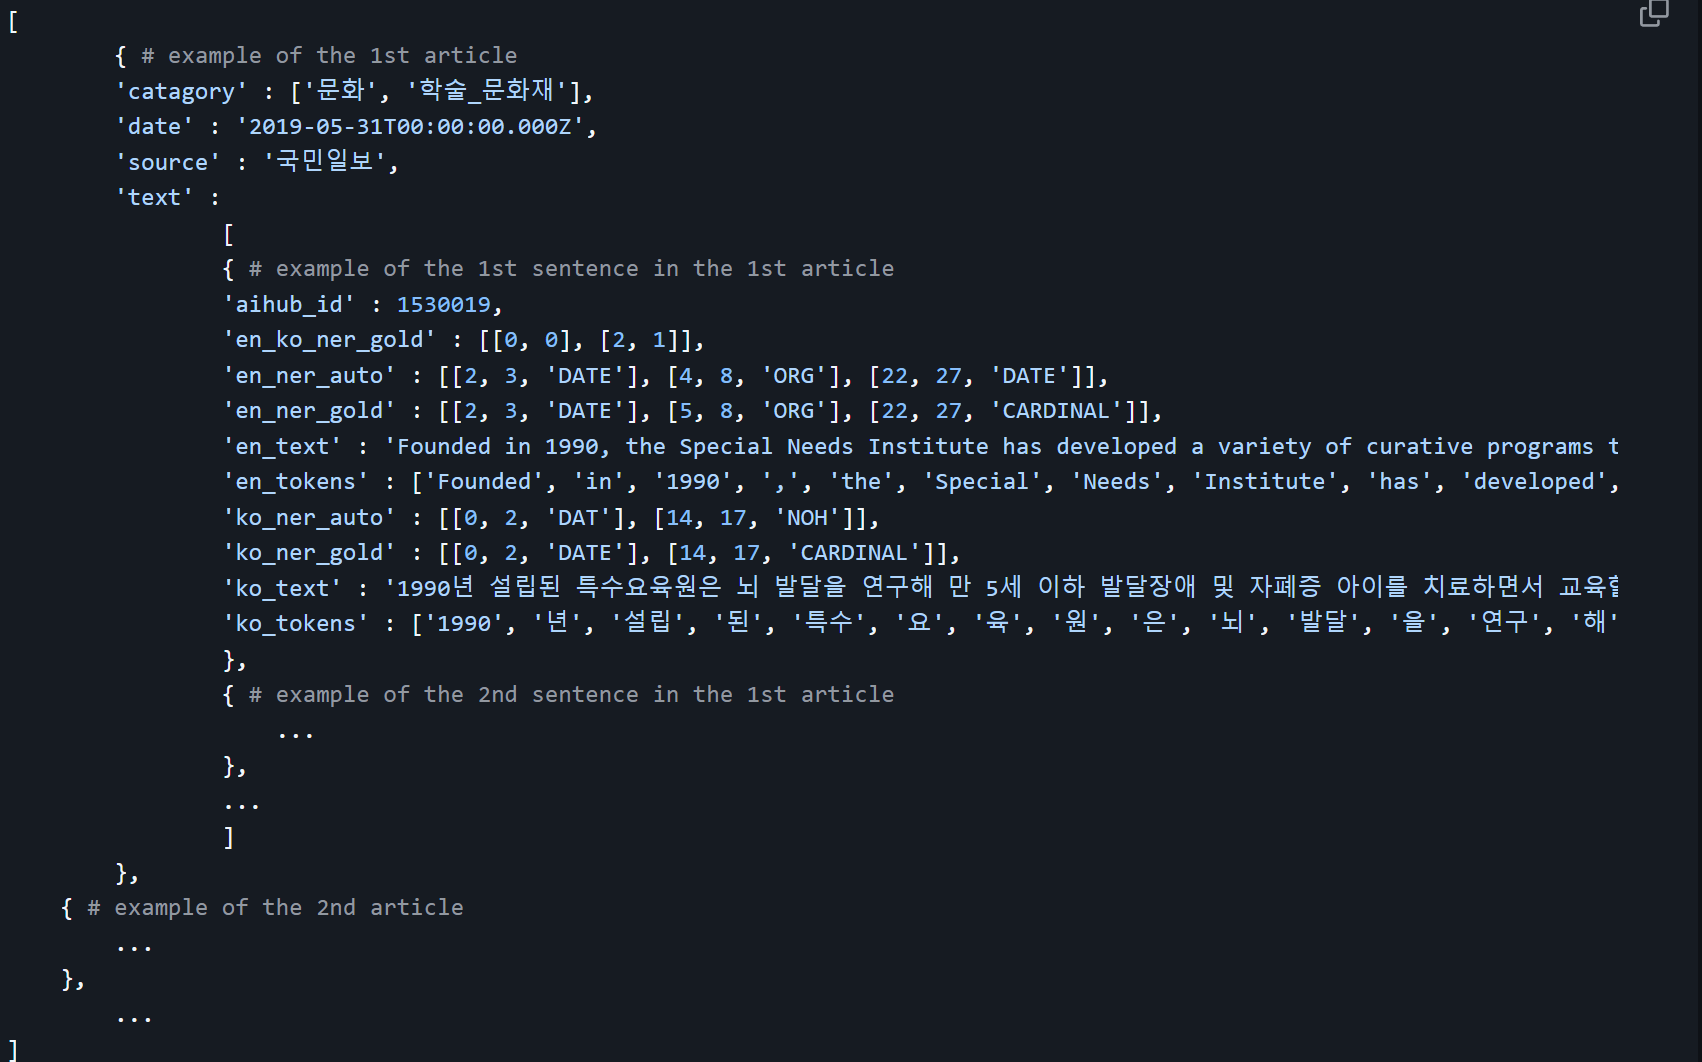

In [ ]:
#dataset load
training_file_path = "/kaggle/input/ai-hub-corpus/ai_hub_train_corpus_small.json"
with open(training_file_path, encoding="utf-8") as f:
    json_data = json.load(f)

texts = []
for article in json_data:
    for item in article["text"]:  # 'text' is a list of dicts
        texts.append({"ko_text": item["ko_text"], "en_text": item["en_text"]})

df_ai = pd.DataFrame(texts)
print(df_ai.head())
print(f"Total AI HUB data entries: {len(df_ai)}")

# Training Data Load from OPUS post 2020 
https://opus.nlpl.eu/OpenSubtitles/ko&en/v2024/OpenSubtitles

The index of the English and Korean Text are match for translation


In [ ]:
#data load from opus post 2020

en_file_path = "/kaggle/input/opus-training-post-2020/opus_data_post_2020_training_en.txt"
kr_file_path = "/kaggle/input/opus-training-post-2020/opus_data_post_2020_training_kr.txt"


with open(en_file_path, encoding="utf-8") as f_en, open(kr_file_path, encoding="utf-8") as f_kr:
    en_lines = [line.strip() for line in f_en]
    kr_lines = [line.strip() for line in f_kr]

# Ensure same number of lines
assert len(en_lines) == len(kr_lines), "Line count mismatch between English and Korean files."

# Build the DataFrame
df_opus = pd.DataFrame({
    "ko_text": kr_lines,
    "en_text": en_lines
})

print(df_opus.head())
print(f"Total OPUS data entries: {len(df_opus)}")


# Training Data Load from OPUS Wikimatrix 

In [6]:
#data load from opus wikimatrix

en_file_path = "/kaggle/input/opus-wikimatrix/WikiMatrix.filtered.dedup.cleaned.noeng.max100.en"
kr_file_path = "/kaggle/input/opus-wikimatrix/WikiMatrix.filtered.dedup.cleaned.noeng.max100.ko"


with open(en_file_path, encoding="utf-8") as f_en, open(kr_file_path, encoding="utf-8") as f_kr:
    en_lines = [line.strip() for line in f_en]
    kr_lines = [line.strip() for line in f_kr]

# Ensure same number of lines
assert len(en_lines) == len(kr_lines), "Line count mismatch between English and Korean files."

# Build the DataFrame
df_opus_wikimatrix = pd.DataFrame({
    "ko_text": kr_lines,
    "en_text": en_lines
})

print(df_opus_wikimatrix.head())
print(f"Total OPUS data entries: {len(df_opus_wikimatrix)}")


                                       ko_text  \
0                                 하며 세조가 진노하였다   
1              "(민 15:37) 여호와께서 모세에게 말씀하여 이르시되   
2                          그는 겸손했고, 친절했으며 관대했다   
3              그것은 하나님께서 모세에게 시나이 산에서 주신 교훈들이다   
4  “모세의 기적”이라 하여 바닷물이 열리는 곳이 있는데 제부도는 그 중 하나이다   

                                             en_text  
0                    Zhu thus became grateful to Han  
1                             "Moses honoured again"  
2  He is the Entirely Merciful, the Especially Me...  
3                                 Yasseen MUSA (QAT)  
4  Salam be upon Musa, the one for whom Allah spl...  
Total OPUS data entries: 194445


# Merge the OPUS, AI HUB data

In [7]:
#df = pd.concat([df_opus_wikimatrix], ignore_index=True)
#random sampling of 10K pairs from wikimatrix 194k pairs.
df = pd.concat([df_opus_wikimatrix], ignore_index=True).head(100000)
print(df.head())
print(f"Total Development data entries:{len(df)}")
wandb.log({"num_of_train_sample": len(df)})

                                       ko_text  \
0                                 하며 세조가 진노하였다   
1              "(민 15:37) 여호와께서 모세에게 말씀하여 이르시되   
2                          그는 겸손했고, 친절했으며 관대했다   
3              그것은 하나님께서 모세에게 시나이 산에서 주신 교훈들이다   
4  “모세의 기적”이라 하여 바닷물이 열리는 곳이 있는데 제부도는 그 중 하나이다   

                                             en_text  
0                    Zhu thus became grateful to Han  
1                             "Moses honoured again"  
2  He is the Entirely Merciful, the Especially Me...  
3                                 Yasseen MUSA (QAT)  
4  Salam be upon Musa, the one for whom Allah spl...  
Total Development data entries:100000


# Metric Evaluation Data loaded from OPUS Eval Metric

In [ ]:
#data load from opus post 2020 for metric evaluation

en_file_path = "/kaggle/input/opus-metric-data-eval/metric_eval_sampled_3000_en.txt"
kr_file_path = "/kaggle/input/opus-metric-data-eval/metric_eval_sampled_3000_kr.txt"


with open(en_file_path, encoding="utf-8") as f_en, open(kr_file_path, encoding="utf-8") as f_kr:
    en_lines = [line.strip() for line in f_en]
    kr_lines = [line.strip() for line in f_kr]

# Ensure same number of lines
assert len(en_lines) == len(kr_lines), "Line count mismatch between English and Korean files."

# Build the DataFrame
df_opus_eval = pd.DataFrame({
    "ko_text": kr_lines,
    "en_text": en_lines
})

print(df_opus_eval.head())
print(f"Total OPUS Eval data entries: {len(df_opus_eval)}")

# Metric Evaluation from AI HUB data

In [9]:
#dataset load
training_file_path = "/kaggle/input/ai-hub-corpus/ai_hub_metric_eval_corpus.json"
with open(training_file_path, encoding="utf-8") as f:
    json_data = json.load(f)

texts = []
for article in json_data:
    for item in article["text"]:  # 'text' is a list of dicts
        texts.append({"ko_text": item["ko_text"], "en_text": item["en_text"]})

df_ai_eval = pd.DataFrame(texts)
print(df_ai_eval.head())
print(f"Total AI HUB data entries: {len(df_ai_eval)}")
wandb.log({"num_of_metric_eval_samples": len(df_ai_eval)})

                                             ko_text  \
0  아내가 외출하기 전 끓여놓은 국과 반찬을 식판에 떠서 먹이기만 하면 되는데 말처럼 ...   
1                매번 잘 차려진 밥상에 숟가락만 들었던 내 모습이 부끄러워진다.   
2  가끔 평일에 일찍 들어가 가족들과 밥을 먹을 때 왜 아내가 그렇게 아이들에게 고함을...   
3  분명 아이들 밥을 차린 시간은 5분이 채 되지 않았는데, 아침식사 시간은 한 시간이...   
4  분명 아내는 아이들이 다 놀고 나면 손쉽게 정리했던 것 같은데 어디서부터 치워야 할...   

                                             en_text  
0  What needs to be done is to scoop up the boile...  
1  I'm ashamed of myself for holding only a spoon...  
2  Sometimes when I got home early on weekdays an...  
3  It has been less than 5 minutes since the chil...  
4  The wife seems to have cleaned up easily after...  
Total AI HUB data entries: 1500


# Translation on the original base model

In [10]:
#src_text = ["내일은 meeting이 있어서 busy해요."]
src_text = ["안녕하세요. 만나서 반갑습니다. "]
inputs = tokenizer(src_text, return_tensors="pt", padding=True).to(DEVICE)

outputs = model.generate(**inputs)

translation = tokenizer.decode(outputs[0], skip_special_tokens = True)


In [11]:
translation

"Hi. I'm glad to meet you."

# Model Predictions and References build-up pre-training phase to find the base model evaluation score

In [ ]:
# predictions = []
# references = []

# for _, row in tqdm(df_opus_eval.iterrows(), total=len(df_opus_eval)):
#     tokenizer.src_lang = "ko_KR"
#     inputs = tokenizer(row["ko_text"], return_tensors="pt", max_length=128, truncation=True, padding="max_length")
#     inputs = {k: v.to(model.device) for k, v in inputs.items()}
#     output_ids = model.generate(**inputs,decoder_start_token_id=tokenizer.convert_tokens_to_ids("en_XX"), max_new_tokens=128)
#     pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
#     predictions.append(pred)
#     references.append([row["en_text"]])


# Compute Bleu Score using Hugging Face evaluate module

In [ ]:
# def bleu_score():
#     print(len(predictions))
#     print(len(references))
#     bleu = evaluate.load("bleu")
#     bleu_score = bleu.compute(predictions=predictions, references=references)
#     print("Corpus BLEU:", bleu_score["bleu"])

# bleu_score()

# Compute BertScore using Hugging Face evaluate module and bert-score

In [ ]:
# def bert_score():
#     bert_score = evaluate.load("bertscore")
#     results = bert_score.compute(predictions=predictions, references=references, lang="en")
#     print("BERTScore Precision:", sum(results["precision"])/len(results["precision"]))
#     print("BERTScore Recall:", sum(results["recall"])/len(results["recall"]))
#     print("BERTScore F1:", sum(results["f1"])/len(results["f1"]))
    
# bert_score()

# Compute chrf++ score of the model both Word and Character

In [ ]:
# def chrf():
#     chrf = evaluate.load("chrf")
#     results = chrf.compute(predictions=predictions, references=references, word_order=2)
#     print("chrF++ score:", results["score"])
# chrf()

# Supervised Model training starts from here

# Batch Size, EPOCHs, Test Size

In [12]:
test_size = 0.25 #used for development phase for train and validation split
BATCH_SIZE = 5
NUM_EPOCHS = 1

In [13]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, df, tokenizer, max_length = 128, src_lang="ko_text", tgt_lang="en_text"):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        src = self.df[self.src_lang].iloc[idx]
        tgt = self.df[self.tgt_lang].iloc[idx]

        src_enc = self.tokenizer(src, return_tensors = "pt", padding="max_length", truncation=True, max_length = self.max_length)
        with self.tokenizer.as_target_tokenizer():
            tgt_enc = self.tokenizer(tgt, return_tensors = "pt", padding="max_length", truncation=True, max_length = self.max_length)

        input_ids = src_enc["input_ids"].squeeze()
        attention_mask = src_enc["attention_mask"].squeeze()
        labels = tgt_enc["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100 #ignore padding in loss calculation
        return{
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels":labels
        }


In [14]:
#dataset split into train and validation data
train_data, test_data = train_test_split(df, test_size = test_size)

In [15]:
train_dataset = TranslationDataset(train_data, tokenizer)
valid_dataset = TranslationDataset(test_data, tokenizer)
#iterator = iter(train_dataset)
#print(next(iterator))

In [16]:
#optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
optimizer = AdamW(model.parameters(), lr=3e-5, betas=(0.9, 0.98), eps=1e-9)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
#train_dataset[0]

In [18]:
def train(model, optimizer, num_epochs, dataloader):
    print('Training started...')
    model.to(DEVICE)
    model.train()

    train_loss = []
    total_batches = len(dataloader)
    effective_batches = math.ceil(total_batches * num_epochs) if num_epochs < 1 else total_batches

    epoch_loss = 0
    num_iter = 0
    start_time = time()

    progress_bar = tqdm(dataloader, total=effective_batches, desc=f"Epoch {num_epochs}", leave=False)

    for batch in progress_bar:
        if num_iter >= effective_batches:
            break

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        num_iter += 1
        progress_bar.set_postfix(loss=loss.item())
        wandb.log({"train_loss": loss.item(), "train_batch": num_iter}) #batch loss

    avg_loss = epoch_loss / num_iter if num_iter > 0 else float("inf")
    train_loss.append(avg_loss)
    elapsed = time() - start_time
    print(f"Training completed in {elapsed:.2f}s — Avg Loss: {avg_loss:.4f}")
    wandb.log({"avg_train_loss": avg_loss})  #avg loss per epoch
    return train_loss
def validate(model, dataloader):
    print('Validating...')
    model.eval()
    total_loss = 0
    num_iter = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            num_iter += 1
            wandb.log({"val_batch_loss": loss.item(), "val_batch": num_iter}) #loss per batch
            #print(f"Eval iter = {num_iter}, Loss: {loss.item():.4f}")

    avg_val_loss = total_loss / num_iter if num_iter > 0 else float("inf")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    wandb.log({"avg_val_loss": avg_val_loss}) #validation loss per epoch
    return avg_val_loss


# Model Training

In [ ]:
train(model, optimizer, NUM_EPOCHS, train_dataloader)

Training started...


Epoch 1:   0%|          | 0/15000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


# Model Validation

In [ ]:
validate(model, valid_dataloader)                                         

# Save the tuned Model

In [ ]:
#save the model
model.save_pretrained("/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning")

#save tokenizer
tokenizer.save_pretrained("/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning-token")

# Load the tuned Model

In [ ]:
#load the fine tuned model
if(torch.cuda.is_available()):
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using {DEVICE}")
finetuned_model = MBartForConditionalGeneration.from_pretrained("/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning").to(DEVICE)
finetuned_tokenizer = MBart50TokenizerFast.from_pretrained("/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning-token")
finetuned_tokenizer.src_lang = "ko_KR"
finetuned_tokenizer.tgt_lang = "en_XX"
#mBART use special language token for identification
finetuned_model.config.decoder_start_token_id = finetuned_tokenizer.convert_tokens_to_ids("en_XX")

In [ ]:
#src_text = ["내일은 meeting이 있어서 busy해요."]
src_text = ["안녕하세요, 만나서 반갑습니다."]
inputs = finetuned_tokenizer(src_text, return_tensors="pt", padding=True).to(DEVICE)

outputs = finetuned_model.generate(**inputs)

translation = finetuned_tokenizer.decode(outputs[0], skip_special_tokens = True)

In [ ]:
translation

# Evaluation Metric Calculation Bleu, BertScore F1, Chrf++

In [ ]:
predictions = []
references = []
df_metric_eval=df_ai_eval
for _, row in tqdm(df_metric_eval.iterrows(), total=len(df_metric_eval)):
    finetuned_tokenizer.src_lang = "ko_KR"
    inputs = finetuned_tokenizer(row["ko_text"], return_tensors="pt", max_length=128, truncation=True, padding="max_length")
    inputs = {k: v.to(finetuned_model.device) for k, v in inputs.items()}
    output_ids = finetuned_model.generate(**inputs,decoder_start_token_id=finetuned_tokenizer.convert_tokens_to_ids("en_XX"), max_new_tokens=128)
    pred = finetuned_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predictions.append(pred)
    references.append([row["en_text"]])



In [ ]:
#!pip install sacrebleu
print("Fine Tuned Model Evaluation Metric Score:")
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=predictions, references=references)
print("Corpus BLEU:", bleu_score["bleu"])
bert_score = evaluate.load("bertscore")
bert_results = bert_score.compute(predictions=predictions, references=references, lang="en")
print("BERTScore Precision:", sum(bert_results["precision"])/len(bert_results["precision"]))
print("BERTScore Recall:", sum(bert_results["recall"])/len(bert_results["recall"]))
print("BERTScore F1:", sum(bert_results["f1"])/len(bert_results["f1"]))
chrf = evaluate.load("chrf")
chrf_results = chrf.compute(predictions=predictions, references=references, word_order=2)
print("chrF++ score:", chrf_results["score"])
wandb.log({
    "bleu": bleu_score["bleu"],
    "chrf++": chrf_results["score"],
    "bertscore_f1": sum(bert_results["f1"])/len(bert_results["f1"])
})

# Download the save model

In [ ]:
import shutil

shutil.make_archive('/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning','zip', 
    '/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning')


shutil.make_archive('/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning-token','zip', 
    '/kaggle/working/facebook/mbart-large-50-many-to-many-mmt-finetuning-token')

